In [1]:
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def loadSimpData():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
datMat,classLabels = loadSimpData()

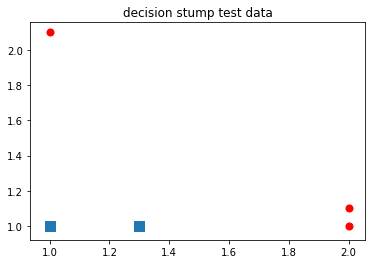

In [5]:
xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []

for i in range(len(classLabels)):
    if classLabels[i]==1.0:
        xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
    else:
        xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
fig = plt.figure()
ax = fig.add_subplot(111)       
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('decision stump test data')
plt.show()

In [6]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [7]:
def buildStump(dataArr,classLabels,D):
    dataMatrix =np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; 
    bestStump = {}; 
    bestClasEst = np.mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); 
        rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                #call stump classify with i, j, lessThan
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print "split: dim %d, thresh %.2f, thresh ineqal: %s,
                #the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst